# AIT Deep Learning Pedestrian Detection Project

## Approach: R-CNN
- We are using Region-based Convolutional Neural Networks to detect the pedestians.
- R-CNN can be divided into two main parts. 
    1. The selective search algorithm generates "proposals" of regions which may have what we are looking for: pedestrians.
    2. CNN categorizes if each proposal contains pedestrians or not.

## Phase 1 TODOs
1. Load images and annotations
2. Create X_train, X_valid, X_test
3. 

### 1-1: Load Images and annotations.

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import pylab
import random
import pickle as pk
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [34]:
# We are using their validation images for testing, as they don't provide a test annotation.
train_anno = 'annotations/dhd_pedestrian_traffic_train.json'
test_anno = 'annotations/dhd_pedestrian_traffic_val.json' 

train_image_dir = "images/train/"
test_image_dir = "images/val/"

coco_train = COCO(train_anno)
coco_test = COCO(test_anno)

random.seed(123)

loading annotations into memory...
Done (t=0.99s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


### Load Sample image and annotation.

In [35]:
# Displaying image with annotation
def show_image(img_type, image_id, image, show_anns=True):
    coco = None
    
    if img_type == "train":
        coco = coco_train
    elif img_type == "valid":
        coco = coco_train
    elif img_type == "test":
        coco = coco_test
    else:
        raise ValueError("Unknown image type")
    
    plt.axis('off')
    plt.imshow(image)
    if show_anns:
        annIds = coco.getAnnIds(imgIds=image_id)
        anns = coco.loadAnns(annIds)
        print("There are", len(annIds), "pedestrians")
        coco.showAnns(anns)

There are 3 pedestrians


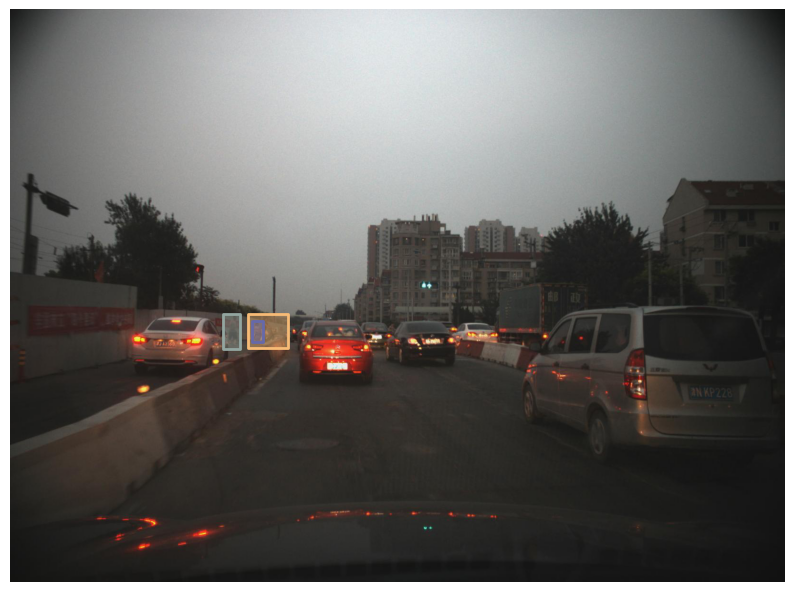

In [36]:
show_image("train", coco_train.getImgIds()[0], io.imread(train_image_dir + coco_train.loadImgs(coco_train.getImgIds()[0])[0]['file_name']))


### Sample Training, Validation, and Test dataset

In [37]:
train_rate = 0.8

train_valid_imgIds = coco_train.getImgIds()
random.shuffle(train_valid_imgIds)

train_imgIds = train_valid_imgIds[:int(train_rate * len(train_valid_imgIds))]
valid_imgIds = train_valid_imgIds[int(train_rate * len(train_valid_imgIds)):]
test_imgIds = coco_test.getImgIds()

print("Number of pictures in the train data     :", len(train_imgIds))
print("Number of pictures in the validation data:", len(valid_imgIds))
print("Number of pictures in the test data      :", len(test_imgIds))

Number of pictures in the train data     : 11086
Number of pictures in the validation data: 2772
Number of pictures in the test data      : 2136


In [56]:
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend

def get_pedestrian_count(img_type, image_id):
    coco = None
    
    if img_type == "train":
        coco = coco_train
    elif img_type == "valid":
        coco = coco_train
    elif img_type == "test":
        coco = coco_test
    else:
        raise ValueError("Unknown image type")

    annIds = coco.getAnnIds(imgIds=image_id)
    num_pedestrians = len(annIds)  
    return num_pedestrians

def load_and_process_image(img_type, image_id):
    coco = None
    image_dir = None
    
    if img_type == "train":
        coco = coco_train
        image_dir = train_image_dir
    elif img_type == "valid":
        coco = coco_train
        image_dir = train_image_dir
    elif img_type == "test":
        coco = coco_test
        image_dir = test_image_dir
    else:
        raise ValueError("Unknown image type")
    
    img = coco.loadImgs(image_id)[0]
    img_path = image_dir + img['file_name']
    img = image_utils.load_img(img_path, target_size=(224, 224))
    img = image_utils.img_to_array(img, data_format="channels_last", dtype="float32") #   
    img = preprocess_input(img) # VGG16 preprocessing
    img = img / 255

    # Get number of pedestrians in the image
    num_pedestrians = get_pedestrian_count(img_type, image_id)

    return img, num_pedestrians

In [63]:
def load_and_process_images(img_type, imgIds):
    images = np.zeros((len(imgIds), 224, 224, 3), dtype=np.float32)
    pedestrian_counts = []
    total_images = len(imgIds)
    progress_interval = total_images // 10  # 10% progress interval
    
    for i, imgId in enumerate(imgIds):
        img, num_pedestrians = load_and_process_image(img_type, imgId)
        images[i] = img
        pedestrian_counts.append(num_pedestrians)
        
        if (i + 1) % progress_interval == 0:
            progress = (i + 1) / total_images * 100
            print(f"Progress: {progress:.0f}%")
    
    return images, np.array(pedestrian_counts)

In [65]:
# X_train, Y_train = load_and_process_images("train", train_imgIds)
# X_valid, Y_valid = load_and_process_images("valid", valid_imgIds)
X_test, Y_test = load_and_process_images("test", test_imgIds)

Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%


In [71]:
Y_test.argmin()

5

In [73]:
Y_test[Y_test.argmax()]

22

In [74]:
del X_test, Y_test